## Group 6 - Math for AI, AI23 @ HCMUS
- 23122013 - Đinh Đức Tài
- 23122002 - Nguyễn Đình Hà Dương
- 23122004 - Nguyễn Lê Hoàng Trung
- 23122014 - Hoàng Minh Trung

## [Lab1] Polynomial Regression

## Part 0: Import libs, define DataProcessor and functions

#### 0.1: Import libs: Numpy, Pandas, Matplotlib

In [1]:
# Importing the libraries: numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from scipy.odr import quadratic

#### 0.2: Create class DataProcessor

In [2]:
class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.original = True

    def load_data(self):
        """Load data from the CSV file."""
        self.data = pd.read_csv(self.file_path)
        print("Data loaded successfully!")
        return self.data
    
    def get_summary(self):
        """Print a summary of the data."""
        print("Number of rows:", len(self.data))
        print("Column names:", self.data.columns.tolist())
        return self.data.describe()
    
    def head(self, n = 5):
        """Return the first n rows of the data."""
        return self.data.head(n)
    
    def null_info(self):
        """Print information about missing values."""
        print("\nNumber of rows with NaN values:", self.data.isna().any(axis=1).sum())

    def get_column_initial_info(self):
        print("\nInformation about the columns:")
        column_info = pd.DataFrame({
            'Column Name': self.data.columns,
            'Description': [
                "Hãng xe", "Mẫu xe", "Giá xe (VNĐ)", "Năm sản xuất", "Số km đã đi", 
                "Loại nhiên liệu", "Hộp số", "Địa điểm bán", "Màu xe", "Số chủ sở hữu trước đó", 
                "Loại người bán", "Dung tích động cơ (cc)", "Công suất tối đa (bhp)", 
                "Mô-men xoắn tối đa (Nm)", "Hệ dẫn động", "Chiều dài xe (mm)", 
                "Chiều rộng xe (mm)", "Chiều cao xe (mm)", "Số chỗ ngồi", 
                "Dung tích bình nhiên liệu (lít)"
            ],
            'Data Type': self.data.dtypes.values,
            'Number of NaN': self.data.isna().sum().values,
            'Unique Values': self.data.nunique().values,
            'Most Frequent Value': self.data.mode().iloc[0].values,
        })

        return column_info
    
    def get_column_after_transform_info(self):
        print("\nInformation about the columns:")
        column_info = pd.DataFrame({
            'Column Name': self.data.columns,
            'Description': [
                "Hãng xe", "Mẫu xe", "Giá xe (VNĐ)", "Năm sản xuất", "Số km đã đi", 
                "Loại nhiên liệu", "Hộp số", "Địa điểm bán", "Màu xe", "Số chủ sở hữu trước đó", 
                "Loại người bán", "Dung tích động cơ (cc)", "Công suất tối đa (bhp)", 
                "Mô-men xoắn tối đa (Nm)", "Hệ dẫn động", "Chiều dài xe (mm)", 
                "Chiều rộng xe (mm)", "Chiều cao xe (mm)", "Số chỗ ngồi", 
                "Dung tích bình nhiên liệu (lít)", 'Vòng tua tại Công suất tối đa (rpm)',
                'Vòng tua tại Mô-men xoắn tối đa (rpm)',
            ],
            'Data Type': self.data.dtypes.values,
            'Number of NaN': self.data.isna().sum().values,
            'Unique Values': self.data.nunique().values,
            'Most Frequent Value': self.data.mode().iloc[0].values,
        })

        return column_info

#### 0.3: Get infomation about unique values functions

In [3]:
def get_some_unique_values(self):
    print("\nUnique values of some columns:")
    print("Fuel Type:", self.data['Fuel Type'].unique())
    print("Transmission:", self.data['Transmission'].unique())
    print("Seller Type:", self.data['Seller Type'].unique())
    print("Drivetrain:", self.data['Drivetrain'].unique())

    print("Owner:", self.data['Owner'].unique())
    print("Seating Capacity:", self.data['Seating Capacity'].unique())

def unique_values(self):
    object_columns = self.data.select_dtypes(include=['object']).columns
    numeric_columns = self.data.select_dtypes(include=['float64', 'int64']).columns

    # List of object columns and their unique values
    object_columns_list = [(col, self.data[col].nunique()) for col in object_columns]

    # List of numeric columns and their unique values
    numeric_columns_list = [(col, self.data[col].nunique()) for col in numeric_columns]

    print("Object Columns and number of unique values: {}".format(len(object_columns_list)))
    print(object_columns_list)

    print("\nNumeric Columns and number of unique values: {}".format(len(numeric_columns_list)))
    print(numeric_columns_list)
    self.numeric_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
    self.object_columns = self.data.select_dtypes(include=['object']).columns
    return numeric_columns, object_columns

DataProcessor.get_some_unique_values = get_some_unique_values
DataProcessor.unique_values = unique_values

#### 0.4: Clean and transform data functions

In [4]:
def clean_data(self):
    """Clean the data by handling missing values and duplicates."""
    # Handle missing values
    # Fill numeric columns with their mean
    numeric_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
    self.data[numeric_columns] = self.data[numeric_columns].fillna(self.data[numeric_columns].mean().astype(int))

    # Fill categorical columns with the most frequent value
    categorical_columns = self.data.select_dtypes(include=['object']).columns
    self.data[categorical_columns] = self.data[categorical_columns].fillna(self.data[categorical_columns].mode().iloc[0])

    # Remove duplicates
    self.data = self.data.drop_duplicates()

    # Reset index after cleaning
    self.data.reset_index(drop=True, inplace=True)

    # Print summary after cleaning
    print("Data cleaned successfully!")
    print("Number of rows after cleaning:", len(self.data))
    print("Number of missing values after cleaning:", self.data.isna().sum().sum())

def transform_data(self):
    """Transform data by standardizing specific columns."""
    # 'Engine' ('cc') -> float
    self.data['Engine'] = self.data['Engine'].astype(str).str.replace(' cc', '').astype(float)

    # Extract RPM values from the original string values before conversion
    if (self.original is True):
        self.data['rpm at Max Power'] = (
            self.data['Max Power']
            .astype(str)
            .str.extract(r'@\s*(\d+)\s*rpm', expand=False)
        )
        self.data['rpm at Max Torque'] = (
            self.data['Max Torque']
            .astype(str)
            .str.extract(r'@\s*(\d+)\s*rpm', expand=False)
        )
    self.original = False

    # Fill missing values with the most frequent value
    self.data['rpm at Max Power'] = self.data['rpm at Max Power'].fillna(self.data['rpm at Max Power'].mode().iloc[0])
    self.data['rpm at Max Torque'] = self.data['rpm at Max Torque'].fillna(self.data['rpm at Max Torque'].mode().iloc[0])

    # 'rpm at Max Power' -> int
    self.data['rpm at Max Power'] = self.data['rpm at Max Power'].astype(int)

    # 'rpm at Max Torque' -> int
    self.data['rpm at Max Torque'] = self.data['rpm at Max Torque'].astype(int)
    
    # 'Max Power' ('bhp') -> int
    self.data['Max Power'] = self.data['Max Power'].astype(str).str.extract(r'(\d+)', expand=False).astype(int)

    # 'Max Torque' ('Nm') -> int
    self.data['Max Torque'] = self.data['Max Torque'].astype(str).str.extract(r'(\d+)', expand=False).astype(int)

    # 'Seating Capacity' -> int
    self.data['Seating Capacity'] = self.data['Seating Capacity'].astype(int)

    # 'Fuel Tank Capacity' -> int
    self.data['Fuel Tank Capacity'] = self.data['Fuel Tank Capacity'].astype(int)

    # 'Owner' -> int
    self.data['Owner'] = self.data['Owner'].map({
        'UnRegistered Car': 0,
        'First': 1,
        'Second': 2,
        'Third': 3,
        'Fourth': 4,
        '4 or More': 5,
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
    })

    self.numeric_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
    self.object_columns = self.data.select_dtypes(include=['object']).columns

    print("Data transformed successfully!")
    print("\nData Transformation Details:")
    print("- 'Engine' (cc) converted to float.")
    print("- 'Max Power' (bhp) converted to integer.")
    print("- 'Max Torque' (Nm) converted to integer.")
    print("- Add 'rpm at Max Power' and converted to integer.")
    print("- Add 'rpm at Max Torque' and converted to integer.")
    print("- 'Seating Capacity' converted to integer.")
    print("- 'Fuel Tank Capacity' converted to integer.")
    print("- 'Owner' converted to numerical categories.")

DataProcessor.clean_data = clean_data
DataProcessor.transform_data = transform_data

#### 0.5: Data visualization functions

In [5]:
def plot_corr_matrix(self, width=12, height=8):
    # Compute the correlation matrix using only numeric features
    corr_matrix = self.data[self.numeric_columns].corr()

    # Plot the correlation matrix using matplotlib
    plt.figure(figsize=(width, height))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.title("Correlation Matrix of Numeric Features")

    # Annotate the matrix with correlation coefficients
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

def plot_distribution_of_numeric_columns(self):
    # Plot histograms for all numeric columns
    num_cols = self.numeric_columns

    num_cols_count = len(num_cols)
    n_cols = 3  # Number of columns in the figure
    n_rows = (num_cols_count + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(num_cols):
        axes[i].hist(self.data[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def box_plot_for_object_columns(self):
    for col in self.object_columns:
        if (col == 'Model'): 
            continue
        plt.figure(figsize=(12, 3))
        categories = self.data[col].unique()
        groups = [self.data.loc[self.data[col] == category, 'Price'] for category in categories]
        plt.boxplot(groups, patch_artist=True, tick_labels=categories)
        plt.title(f'Box Plot: Price by {col}')
        plt.xlabel(col)
        plt.ylabel('Price')
        if (col == 'Location'):
            plt.xticks(rotation=90)
        elif (col == 'Fuel Type' or col == 'Transmission' or col == 'Seller Type' or col == 'Drivetrain'):
            plt.xticks(rotation=0)
        else:
            plt.xticks(rotation=60)
        plt.show()

def scatter_plot_for_numeric_columns(self):
    cols = [col for col in self.numeric_columns if col != 'Price']
    n_plots = len(cols)
    n_cols = 3
    n_rows = int(n_plots / n_cols) + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        axes[i].scatter(self.data[col], self.data['Price'], alpha=0.5, color='blue', edgecolors='k')
        axes[i].set_title(f'Relationship between Price and {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')
        axes[i].grid(True, linestyle='--', alpha=0.7)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

DataProcessor.plot_corr_matrix = plot_corr_matrix
DataProcessor.plot_distribution_of_numeric_columns = plot_distribution_of_numeric_columns
DataProcessor.box_plot_for_object_columns = box_plot_for_object_columns
DataProcessor.scatter_plot_for_numeric_columns = scatter_plot_for_numeric_columns

#### 0.6: Split dataset to train set and validation set

In [6]:
def train_valid_split(self, valid_size=0.2, random_state=None):
    """Split the data into training and validation sets."""
    train_set = copy.deepcopy(self)
    valid_set = copy.deepcopy(self)
    # Set random seed if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle indices and compute the split index
    indices = np.arange(len(self.data))
    np.random.shuffle(indices)
    split_idx = int((1 - valid_size) * len(self.data))

    # Split the data into training and validation sets
    train_indices = indices[:split_idx]
    valid_indices = indices[split_idx:]
    train_set.data = self.data.iloc[train_indices].reset_index(drop=True)
    valid_set.data = self.data.iloc[valid_indices].reset_index(drop=True)

    return train_set, valid_set

DataProcessor.train_valid_split = train_valid_split

#### 0.7: Data Encoding

In [7]:
def encode_data(self):
    """
    Mã hóa các biến theo yêu cầu:
    - Hãng xe (Make): thay thế bằng giá trung vị của các xe thuộc hãng đó
    - Mẫu xe (Model): thay thế bằng giá trung vị của các xe cùng mẫu
    - Loại nhiên liệu (Fuel Type): Hybrid -> 1; Ngược lại -> 0
    - Hộp số (Transmission): Auto -> 1; Manual -> 0
    - Địa điểm (Location): nếu giá trung vị của Location ≥ giá trung vị toàn cục -> 1; ngược lại -> 0
    - Màu sắc (Color): Black, Blue, Yellow -> 1; ngược lại -> 0
    - Loại người bán (Seller Type): Corporate -> 1; Individual và Commercial Registration -> 0
    - Drivetrain: FWD -> 1, RWD -> 2, AWD -> 3
    """
    # Hãng xe: map giá trung vị theo Make
    make_median = self.data.groupby('Make')['Price'].median()
    self.data['Make'] = self.data['Make'].map(make_median)
    
    # Mẫu xe: map giá trung vị theo Model
    model_median = self.data.groupby('Model')['Price'].median()
    self.data['Model'] = self.data['Model'].map(model_median)
    
    # Loại nhiên liệu: chỉ giữ Hybrid = 1, còn lại = 0
    self.data['Fuel Type'] = self.data['Fuel Type'].apply(lambda x: 1 if x.strip().lower() == 'hybrid' else 0)
    
    # Hộp số: Auto = 1; Manual = 0
    self.data['Transmission'] = self.data['Transmission'].apply(lambda x: 1 if 'auto' in x.strip().lower() else 0)
    
    # Địa điểm: chia theo giá trung vị so với toàn bộ data
    global_median_price = self.data['Price'].median()
    location_medians = self.data.groupby('Location')['Price'].median()
    def encode_location(loc):
        return 1 if location_medians.loc[loc] >= global_median_price else 0
    self.data['Location'] = self.data['Location'].apply(encode_location)
    
    # Màu sắc: Black, Blue, Yellow -> 1; khác -> 0
    self.data['Color'] = self.data['Color'].apply(lambda x: 1 if x.strip().lower() in ['black', 'blue', 'yellow'] else 0)
    
    # Loại người bán: Corporate = 1; Individual và Commercial Registration = 0
    self.data['Seller Type'] = self.data['Seller Type'].apply(lambda x: 1 if x.strip().lower() == 'corporate' else 0)
    
    # Drivetrain: FWD = 1, RWD = 2, AWD = 3
    drivetrain_mapping = {'FWD': 1, 'RWD': 2, 'AWD': 3}
    self.data['Drivetrain'] = self.data['Drivetrain'].map(drivetrain_mapping)
    
    print("Data encoding completed!")
    
# Gắn hàm encode_data vào class DataProcessor
DataProcessor.encode_data = encode_data

#### 0.8: Data Normalization

In [8]:
def normalize_data(self):
    """
    Chuẩn hóa các feature dữ liệu:
    - Áp dụng log transformation cho 'Price' và 'Year' nhằm giảm ảnh hưởng do độ lệch quy mô.
    - Sau đó dùng MinMaxScaler chuẩn hóa toàn bộ các biến số."
    """

    # Áp dụng log1p (log(1+x)) để tránh lỗi với giá trị 0
    self.data['Price Norm'] = np.log1p(self.data['Price'])
    self.data['Year'] = np.log1p(self.data['Year'])
    
    # Chọn các cột số để scale
    numeric_cols = self.data.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = numeric_cols.drop(['Price', 'Price Norm'])
    
    min_vals = self.data[numeric_cols].min()
    max_vals = self.data[numeric_cols].max()
    range_vals = max_vals - min_vals
    # Avoid division by zero by replacing 0 differences with 1
    range_vals[range_vals == 0] = 1
    self.data[numeric_cols] = (self.data[numeric_cols] - min_vals) / range_vals
    
    self.unique_values()
    print("Data normalization completed!")
    
DataProcessor.normalize_data = normalize_data

## Part I: Load and Explore data (train.csv)
In this part, we will load and explore some information about the original data.

In [9]:
# Initialize the DataProcessor class and load the data (train.csv)
file_path = './data/train.csv'
data = DataProcessor(file_path)
data.load_data()

# Print summary of the data
print("\nSummary of the data:")
data.get_summary()

# First 5 rows of data
print("\nFirst 5 rows of data:")
data.head()

Data loaded successfully!

Summary of the data:
Number of rows: 1647
Column names: ['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']

First 5 rows of data:


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,Individual,1995 cc,184 bhp @ 4000 rpm,350 Nm @ 1750 rpm,RWD,4454.0,2044.0,1545.0,5.0,63.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,Individual,1997 cc,138 bhp @ 3750 rpm,320 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,Individual,2925 cc,326 bhp @ 3600 rpm,700 Nm @ 1200 rpm,AWD,5207.0,2157.0,1823.0,7.0,90.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,Individual,2755 cc,174 bhp @ 3400 rpm,450 Nm @ 1600 rpm,RWD,4795.0,1855.0,1835.0,7.0,80.0


In [10]:
# Print information about the null values
data.null_info()

# Print information about the columns
data.get_column_initial_info()


Number of rows with NaN values: 149

Information about the columns:


,Column Name,Description,Data Type,Number of NaN,Unique Values,Most Frequent Value
0,Make,Hãng xe,object,0,31,Maruti Suzuki
1,Model,Mẫu xe,object,0,912,X1 sDrive20d xLine
2,Price,Giá xe (VNĐ),int64,0,564,425000
3,Year,Năm sản xuất,int64,0,21,2017
4,Kilometer,Số km đã đi,int64,0,701,42000
5,Fuel Type,Loại nhiên liệu,object,0,8,Diesel
6,Transmission,Hộp số,object,0,2,Manual
7,Location,Địa điểm bán,object,0,76,Mumbai
8,Color,Màu xe,object,0,17,White
9,Owner,Số chủ sở hữu trước đó,object,0,6,First


In [11]:
# Print the unique values of some columns
data.get_some_unique_values()


Unique values of some columns:
Fuel Type: ['Diesel' 'Petrol' 'CNG' 'LPG' 'CNG + CNG' 'Electric' 'Hybrid'
 'Petrol + LPG']
Transmission: ['Automatic' 'Manual']
Seller Type: ['Individual' 'Corporate' 'Commercial Registration']
Drivetrain: [nan 'RWD' 'FWD' 'AWD']
Owner: ['Second' 'First' 'Third' 'UnRegistered Car' '4 or More' 'Fourth']
Seating Capacity: [nan  5.  7.  2.  6.  8.  4.]


## Part II: Data Preprocessing
In this part, we will fill NaN values and perform some data transformation.

#### II.0: Split dataset

In [12]:
train_data, valid_data = data.train_valid_split(valid_size=0.2, random_state=0)

#### II.1: Data cleaning

In [13]:
# Clean the data and fill missing values
train_data.clean_data()
valid_data.clean_data()

Data cleaned successfully!
Number of rows after cleaning: 1317
Number of missing values after cleaning: 0
Data cleaned successfully!
Number of rows after cleaning: 330
Number of missing values after cleaning: 0


#### II.2: Data Transformation

In [14]:
# Transform the data
train_data.transform_data()
valid_data.transform_data()

Data transformed successfully!

Data Transformation Details:
- 'Engine' (cc) converted to float.
- 'Max Power' (bhp) converted to integer.
- 'Max Torque' (Nm) converted to integer.
- Add 'rpm at Max Power' and converted to integer.
- Add 'rpm at Max Torque' and converted to integer.
- 'Seating Capacity' converted to integer.
- 'Fuel Tank Capacity' converted to integer.
- 'Owner' converted to numerical categories.
Data transformed successfully!

Data Transformation Details:
- 'Engine' (cc) converted to float.
- 'Max Power' (bhp) converted to integer.
- 'Max Torque' (Nm) converted to integer.
- Add 'rpm at Max Power' and converted to integer.
- Add 'rpm at Max Torque' and converted to integer.
- 'Seating Capacity' converted to integer.
- 'Fuel Tank Capacity' converted to integer.
- 'Owner' converted to numerical categories.


#### II.3: Explore train data after preprocessing

In [15]:
train_data.get_column_after_transform_info()


Information about the columns:


,Column Name,Description,Data Type,Number of NaN,Unique Values,Most Frequent Value
0,Make,Hãng xe,object,0,31,Maruti Suzuki
1,Model,Mẫu xe,object,0,785,X1 sDrive20d xLine
2,Price,Giá xe (VNĐ),int64,0,504,425000.0
3,Year,Năm sản xuất,int64,0,19,2017.0
4,Kilometer,Số km đã đi,int64,0,586,65000
5,Fuel Type,Loại nhiên liệu,object,0,7,Diesel
6,Transmission,Hộp số,object,0,2,Manual
7,Location,Địa điểm bán,object,0,75,Mumbai
8,Color,Màu xe,object,0,17,White
9,Owner,Số chủ sở hữu trước đó,int64,0,6,1.0


In [16]:
train_data.get_some_unique_values()


Unique values of some columns:
Fuel Type: ['Diesel' 'Petrol' 'CNG' 'Electric' 'Hybrid' 'LPG' 'CNG + CNG']
Transmission: ['Automatic' 'Manual']
Seller Type: ['Individual' 'Commercial Registration' 'Corporate']
Drivetrain: ['RWD' 'AWD' 'FWD']
Owner: [1 2 3 0 5 4]
Seating Capacity: [5 7 4 6 8 2]


In [17]:
# Print number of unique values for each column
numeric_columns, object_columns = train_data.unique_values()
train_data_after_preprocessing = copy.deepcopy(train_data)
validation_data_after_preprocessing = copy.deepcopy(valid_data)

Object Columns and number of unique values: 8
[('Make', 31), ('Model', 785), ('Fuel Type', 7), ('Transmission', 2), ('Location', 75), ('Color', 17), ('Seller Type', 3), ('Drivetrain', 3)]

Numeric Columns and number of unique values: 14
[('Price', 504), ('Year', 19), ('Kilometer', 586), ('Owner', 6), ('Engine', 98), ('Max Power', 151), ('Max Torque', 122), ('Length', 216), ('Width', 150), ('Height', 180), ('Seating Capacity', 6), ('Fuel Tank Capacity', 49), ('rpm at Max Power', 35), ('rpm at Max Torque', 44)]


## Part III: Data visualization

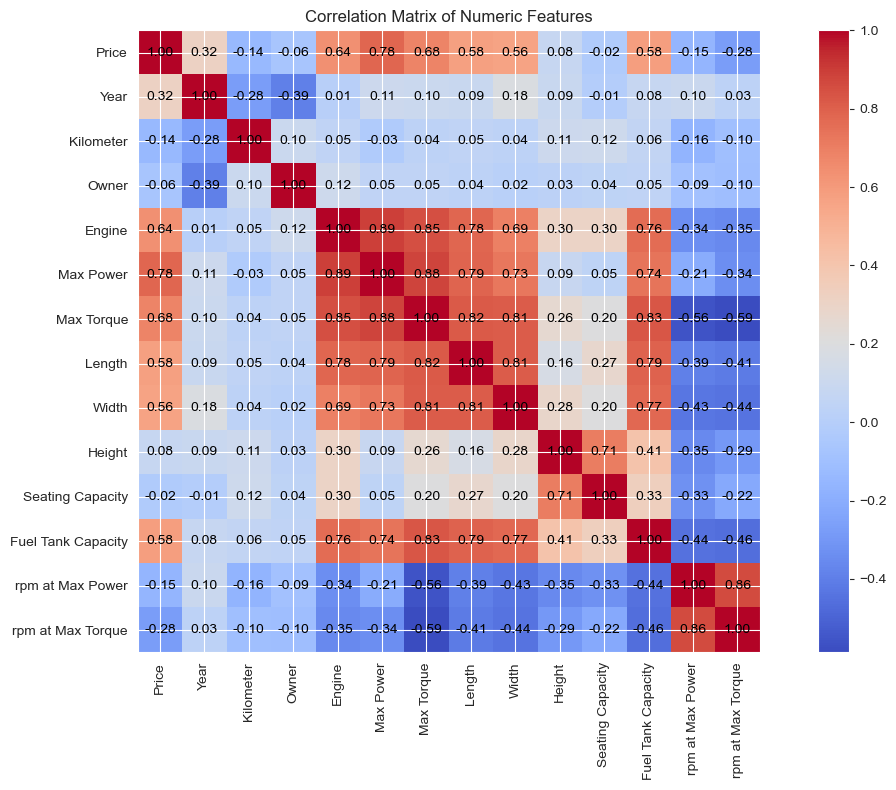

In [18]:
# 1. Plot the correlation matrix
train_data.plot_corr_matrix()

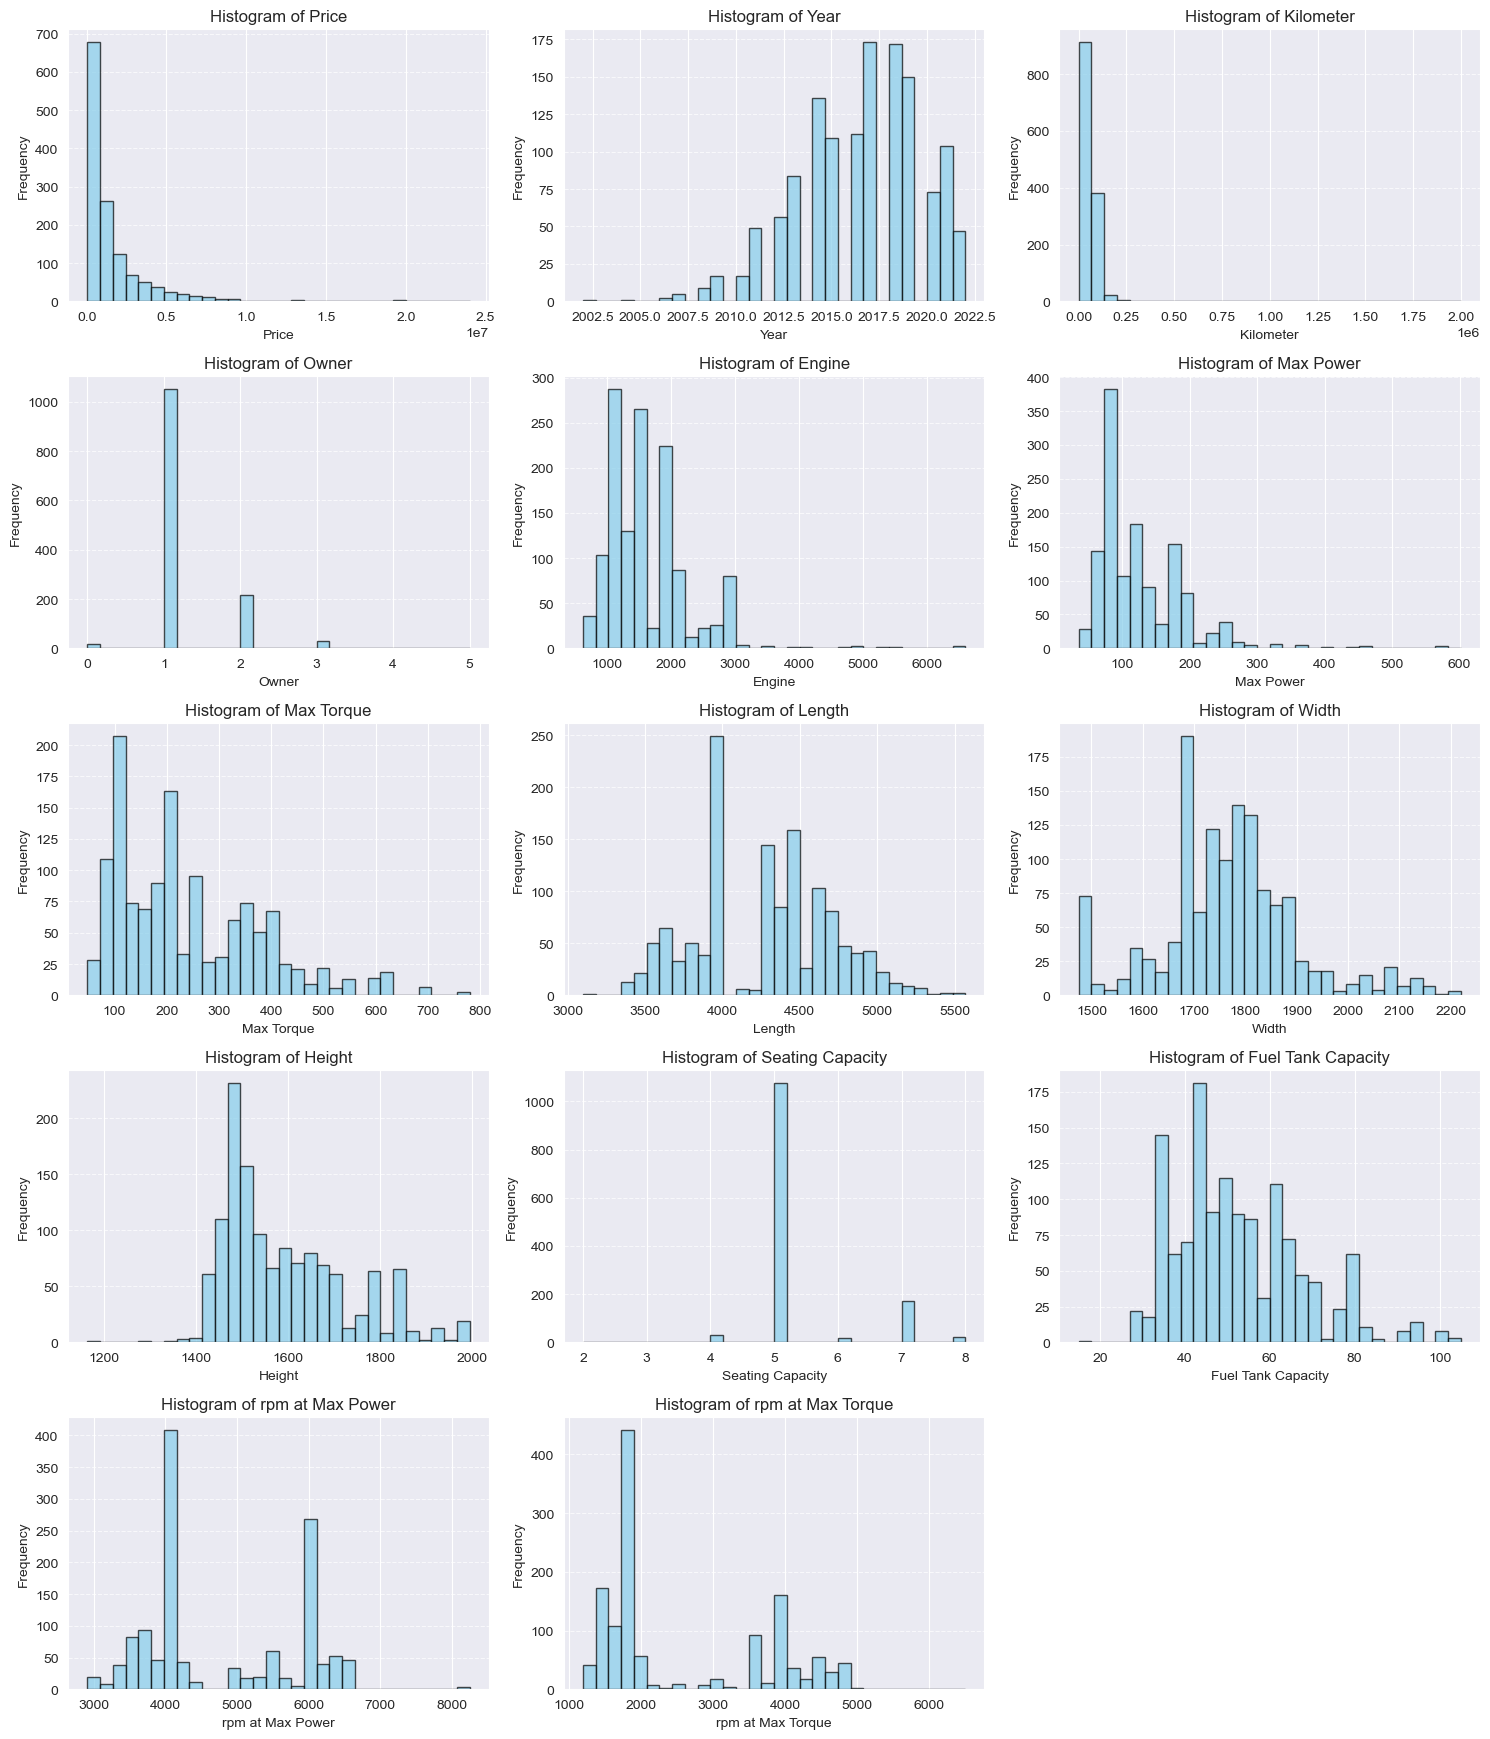

In [19]:
# 2. Plot the distribution of numeric columns
train_data.plot_distribution_of_numeric_columns()

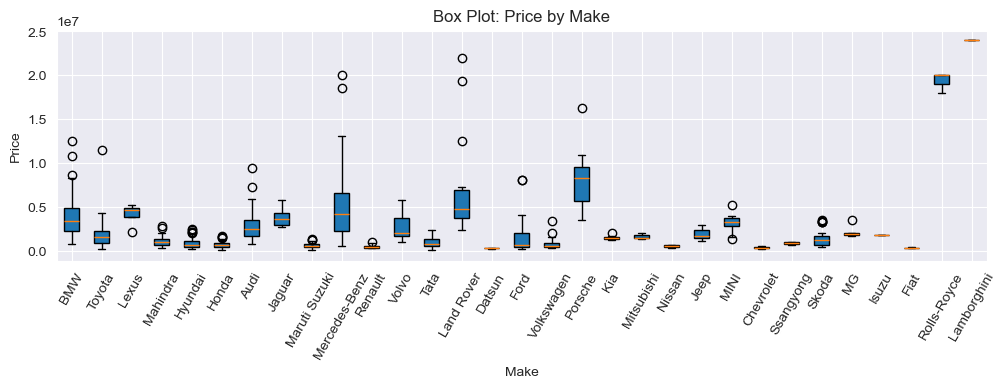

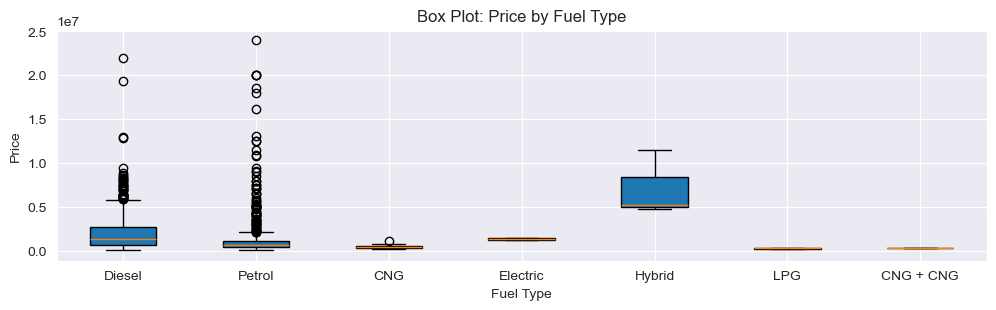

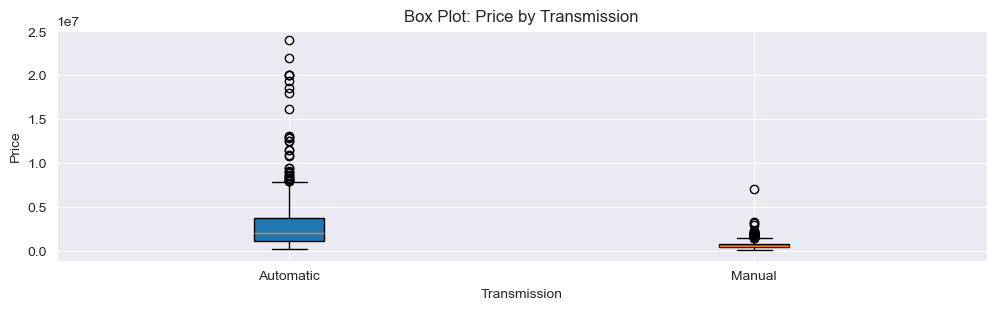

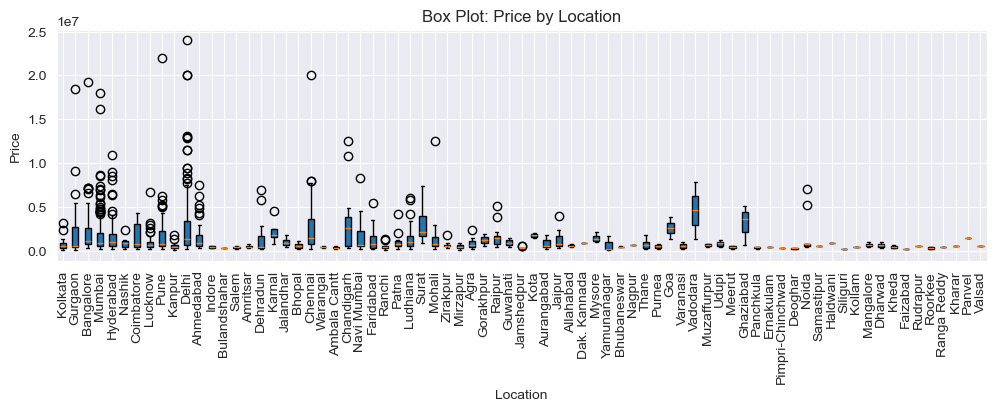

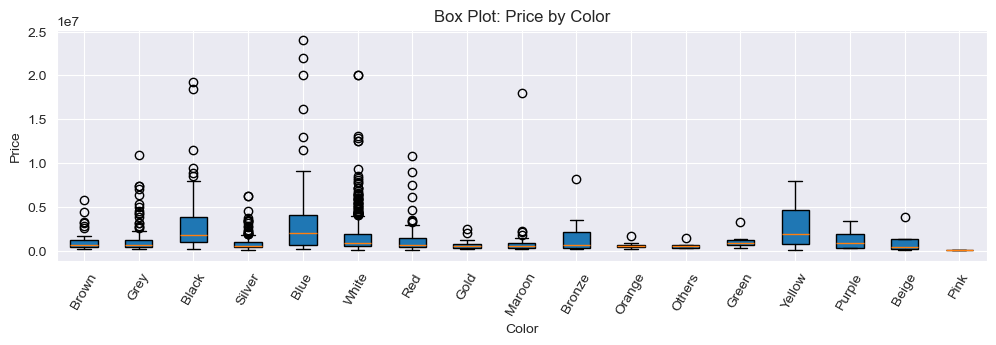

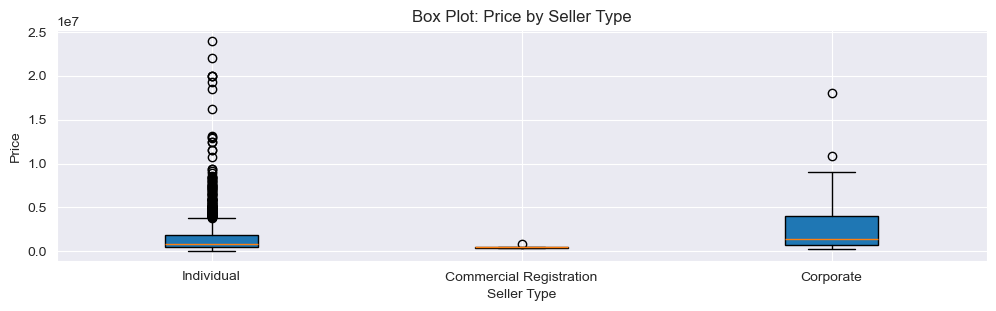

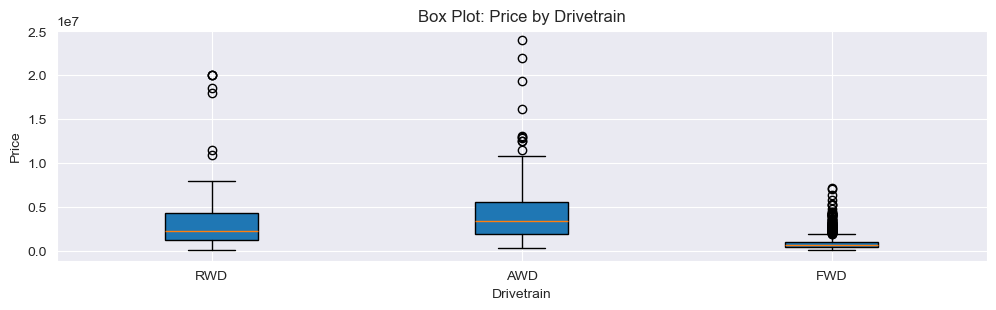

In [20]:
# 3. Box plot: Relationship between Price and Object Columns
train_data.box_plot_for_object_columns()

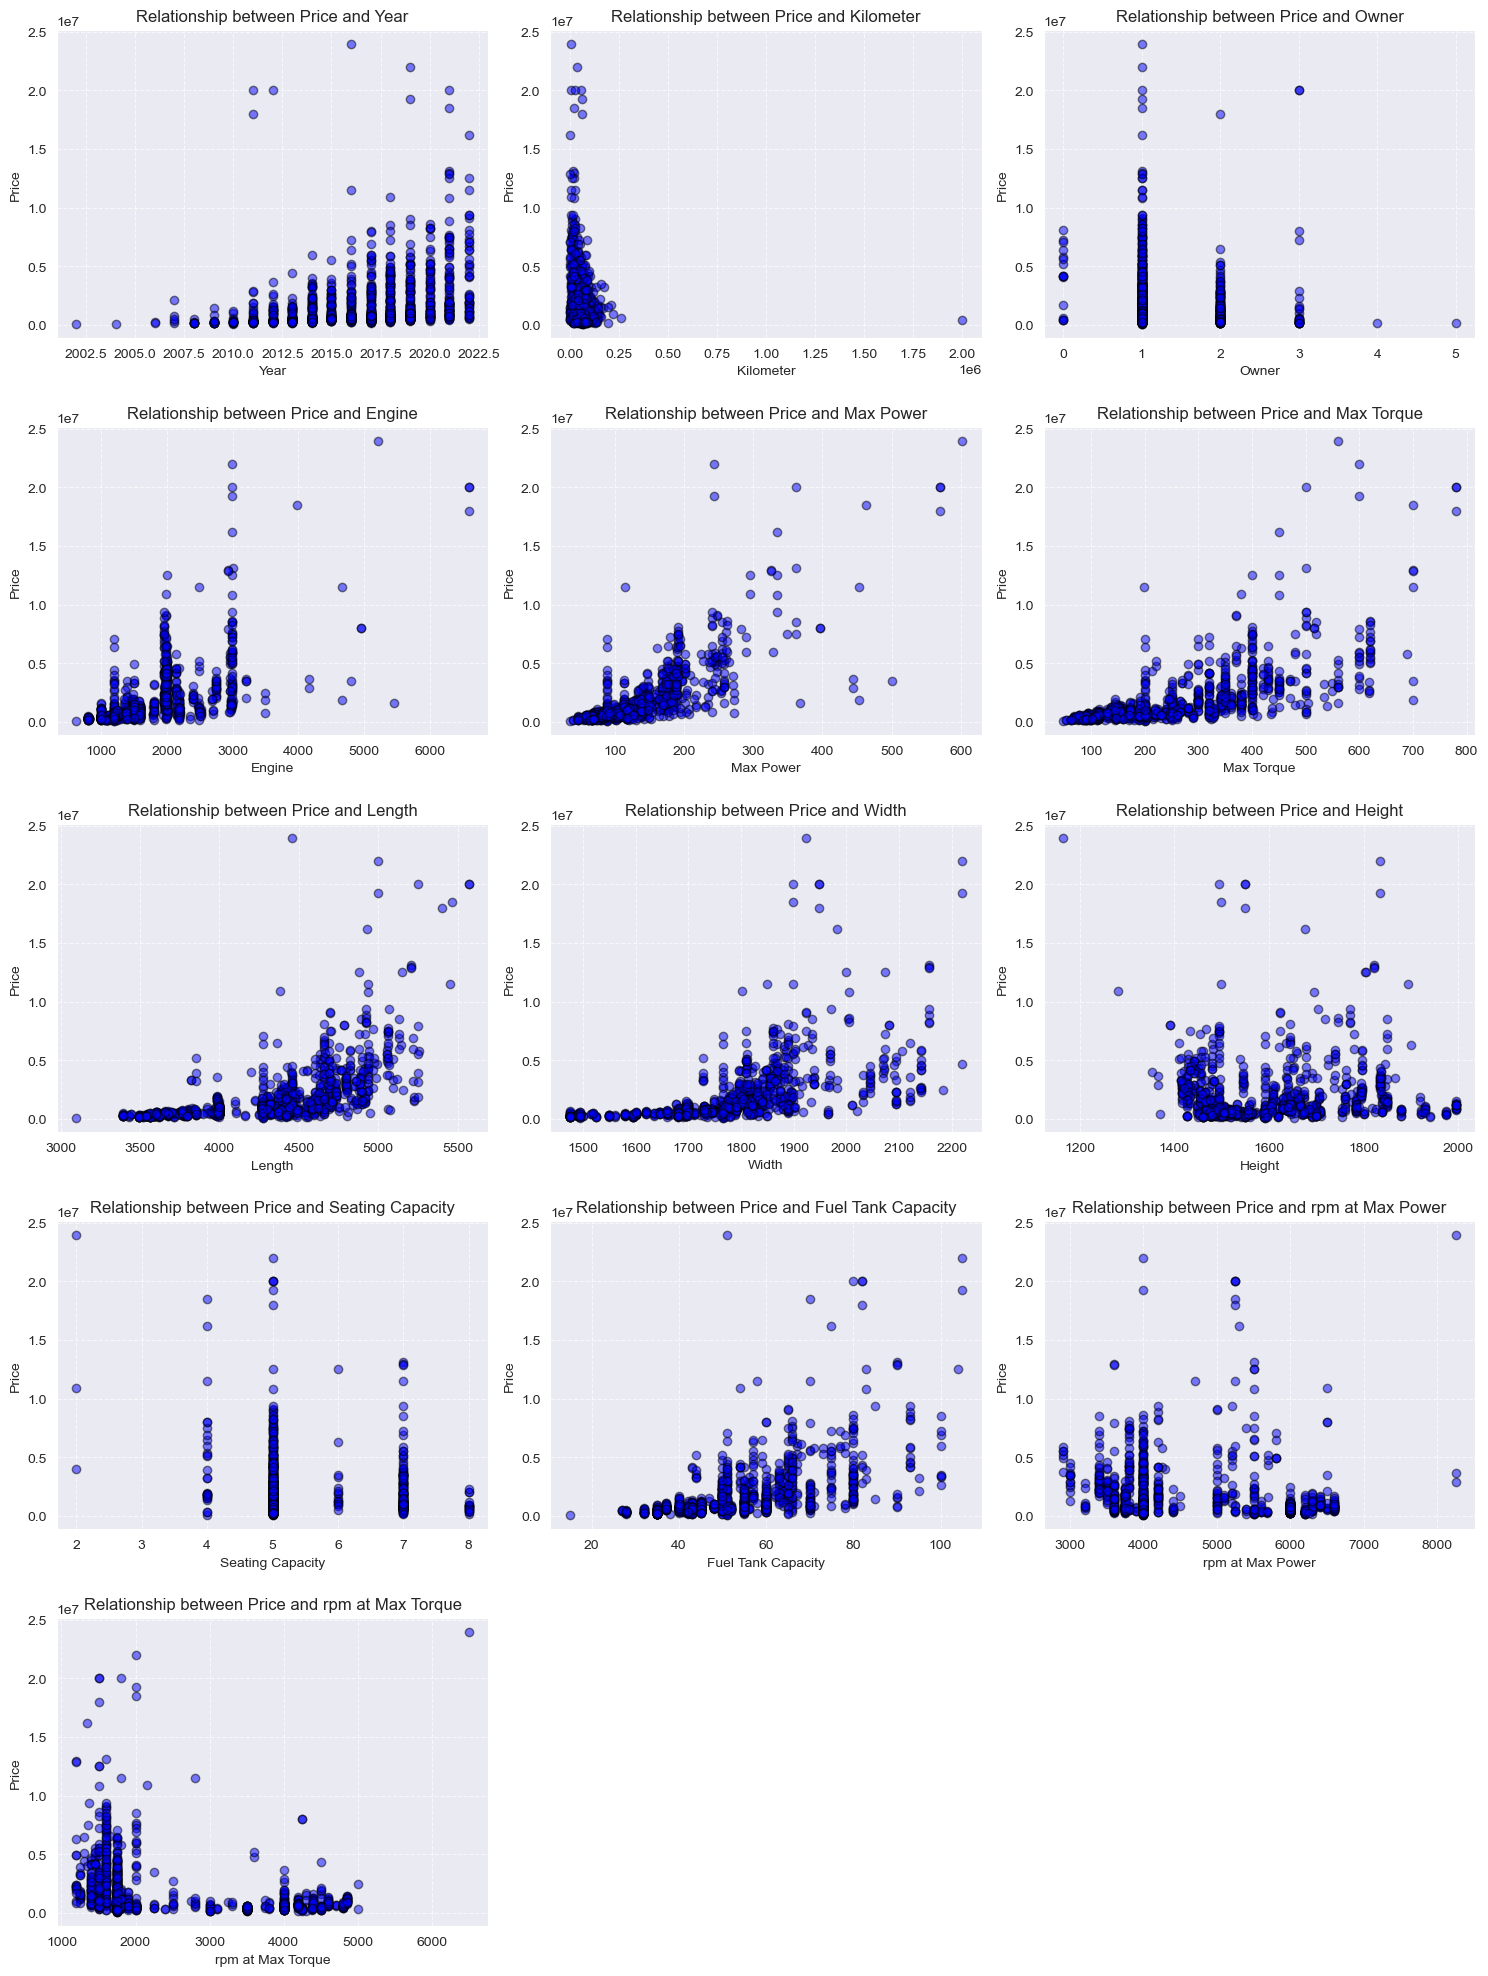

In [21]:
# 3. Scatter Plot: Relationship between Price and Numeric Columns
train_data.scatter_plot_for_numeric_columns()

## Part IV: Data Encoding and Data Normalization

#### IV.1: Data split: Train set and Validation set
We will use train data and validation data (after preprocessing)
- train_data_after_preprocessing
- validation_data_after_preprocessing

#### IV.2: Data Encoding

In [22]:
train_data = copy.deepcopy(train_data_after_preprocessing) # after preprocessing
numeric_columns, object_columns = train_data.unique_values()
print()
validation_data = copy.deepcopy(validation_data_after_preprocessing) # after preprocessing
numeric_columns, object_columns = validation_data.unique_values()

Object Columns and number of unique values: 8
[('Make', 31), ('Model', 785), ('Fuel Type', 7), ('Transmission', 2), ('Location', 75), ('Color', 17), ('Seller Type', 3), ('Drivetrain', 3)]

Numeric Columns and number of unique values: 14
[('Price', 504), ('Year', 19), ('Kilometer', 586), ('Owner', 6), ('Engine', 98), ('Max Power', 151), ('Max Torque', 122), ('Length', 216), ('Width', 150), ('Height', 180), ('Seating Capacity', 6), ('Fuel Tank Capacity', 49), ('rpm at Max Power', 35), ('rpm at Max Torque', 44)]

Object Columns and number of unique values: 8
[('Make', 23), ('Model', 284), ('Fuel Type', 6), ('Transmission', 2), ('Location', 49), ('Color', 14), ('Seller Type', 2), ('Drivetrain', 3)]

Numeric Columns and number of unique values: 14
[('Price', 232), ('Year', 17), ('Kilometer', 212), ('Owner', 5), ('Engine', 65), ('Max Power', 91), ('Max Torque', 82), ('Length', 124), ('Width', 97), ('Height', 109), ('Seating Capacity', 6), ('Fuel Tank Capacity', 37), ('rpm at Max Power', 29),

In [23]:
train_data.encode_data()
train_data.get_column_after_transform_info()
train_data_after_encoding = copy.deepcopy(train_data)

validation_data.encode_data()
validation_data.get_column_after_transform_info()
validation_data_after_encoding = copy.deepcopy(validation_data)

Data encoding completed!

Information about the columns:
Data encoding completed!

Information about the columns:


#### IV.3: Data Normalization

In [24]:
train_data = copy.deepcopy(train_data_after_encoding)
train_data.data.describe()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,rpm at Max Power,rpm at Max Torque
count,1.317000e+03,1.317000e+03,1.317000e+03,1317.000000,1.317000e+03,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,...,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,1.479659e+06,1.683559e+06,1.688176e+06,2016.436598,5.418505e+04,0.002278,0.446469,0.627942,0.180714,1.204252,...,127.804860,241.184510,1.401670,4276.556568,1766.558846,1591.199696,5.290812,51.927866,4751.312073,2543.649203
std,1.735823e+06,2.390192e+06,2.400416e+06,3.251836,6.241336e+04,0.047691,0.497315,0.483537,0.384927,0.496229,...,66.483634,138.731132,0.699824,440.014789,134.482416,134.238408,0.795895,14.769715,1080.668569,1182.014360
min,2.700000e+05,4.900000e+04,4.900000e+04,2002.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,35.000000,48.000000,1.000000,3099.000000,1475.000000,1165.000000,2.000000,15.000000,2910.000000,1200.000000
25%,5.200000e+05,4.750000e+05,4.800000e+05,2014.000000,2.900000e+04,0.000000,0.000000,0.000000,0.000000,1.000000,...,83.000000,115.000000,1.000000,3990.000000,1695.000000,1485.000000,5.000000,42.000000,4000.000000,1750.000000
50%,6.425000e+05,8.050000e+05,8.230000e+05,2017.000000,5.000000e+04,0.000000,0.000000,1.000000,0.000000,1.000000,...,109.000000,200.000000,1.000000,4315.000000,1766.000000,1550.000000,5.000000,50.000000,4000.000000,1750.000000
75%,1.791000e+06,1.875000e+06,1.850000e+06,2019.000000,7.200000e+04,0.000000,1.000000,1.000000,0.000000,1.000000,...,168.000000,343.000000,2.000000,4600.000000,1831.000000,1670.000000,5.000000,60.000000,6000.000000,4000.000000
max,2.400000e+07,2.400000e+07,2.400000e+07,2022.000000,2.000000e+06,1.000000,1.000000,1.000000,1.000000,5.000000,...,602.000000,780.000000,3.000000,5569.000000,2220.000000,1995.000000,8.000000,105.000000,8250.000000,6500.000000


In [25]:
train_data.normalize_data()
train_data_after_normalization = copy.deepcopy(train_data)
train_data_after_normalization.data.describe()

Object Columns and number of unique values: 0
[]

Numeric Columns and number of unique values: 23
[('Make', 31), ('Model', 473), ('Price', 504), ('Year', 19), ('Kilometer', 586), ('Fuel Type', 2), ('Transmission', 2), ('Location', 2), ('Color', 2), ('Owner', 6), ('Seller Type', 2), ('Engine', 98), ('Max Power', 151), ('Max Torque', 122), ('Drivetrain', 3), ('Length', 216), ('Width', 150), ('Height', 180), ('Seating Capacity', 6), ('Fuel Tank Capacity', 49), ('rpm at Max Power', 35), ('rpm at Max Torque', 44), ('Price Norm', 504)]
Data normalization completed!


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,rpm at Max Power,rpm at Max Torque,Price Norm
count,1317.000000,1317.000000,1.317000e+03,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,...,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,0.050976,0.068246,1.688176e+06,0.722695,0.027093,0.002278,0.446469,0.627942,0.180714,0.240850,...,0.263913,0.200835,0.476744,0.391354,0.513494,0.548469,0.410310,0.344815,0.253519,13.792564
std,0.073149,0.099795,2.400416e+06,0.162298,0.031207,0.047691,0.497315,0.483537,0.384927,0.099246,...,0.189523,0.349912,0.178144,0.180513,0.161733,0.132649,0.164108,0.202372,0.223022,0.980481
min,0.000000,0.000000,4.900000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.799596
25%,0.010535,0.017786,4.800000e+05,0.601191,0.014500,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.091530,0.000000,0.360729,0.295302,0.385542,0.500000,0.300000,0.204120,0.103774,13.081543
50%,0.015697,0.031564,8.230000e+05,0.750930,0.025000,0.000000,0.000000,1.000000,0.000000,0.200000,...,0.207650,0.000000,0.492308,0.390604,0.463855,0.500000,0.388889,0.204120,0.103774,13.620713
75%,0.064096,0.076239,1.850000e+06,0.850632,0.036000,0.000000,1.000000,1.000000,0.000000,0.200000,...,0.403005,0.500000,0.607692,0.477852,0.608434,0.500000,0.500000,0.578652,0.528302,14.430697
max,1.000000,1.000000,2.400000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.993564


In [26]:
validation_data = copy.deepcopy(validation_data_after_encoding)
validation_data.data.describe()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,rpm at Max Power,rpm at Max Torque
count,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,330.000000,330.0,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,1.497409e+06,1.717321e+06,1.730494e+06,2016.351515,54291.412121,0.0,0.478788,0.639394,0.142424,1.275758,...,129.972727,255.809091,1.496970,4300.912121,1771.545455,1597.248485,5.339394,52.787879,4783.230303,2442.793939
std,1.280127e+06,2.171674e+06,2.197913e+06,3.811367,39210.945109,0.0,0.500308,0.480906,0.350015,0.539915,...,57.255009,142.825217,0.764916,445.205435,136.549398,134.092714,0.839720,15.782830,1066.983169,1130.969883
min,3.325000e+05,1.149990e+05,1.149990e+05,1988.000000,600.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,46.000000,69.000000,1.000000,3395.000000,1475.000000,1297.000000,2.000000,27.000000,2910.000000,1200.000000
25%,5.000000e+05,4.675000e+05,4.762500e+05,2014.000000,28250.000000,0.0,0.000000,0.000000,0.000000,1.000000,...,82.000000,115.000000,1.000000,3987.750000,1695.000000,1494.000000,5.000000,42.000000,3800.000000,1600.000000
50%,1.050000e+06,9.500000e+05,9.630000e+05,2017.000000,48579.500000,0.0,0.000000,1.000000,0.000000,1.000000,...,118.000000,235.000000,1.000000,4375.000000,1777.000000,1555.000000,5.000000,50.000000,4200.000000,1750.000000
75%,2.400000e+06,2.280625e+06,2.337500e+06,2019.000000,71667.250000,0.0,1.000000,1.000000,0.000000,1.000000,...,174.000000,360.000000,2.000000,4633.000000,1838.000000,1688.750000,5.000000,62.250000,6000.000000,3687.500000
max,5.900000e+06,2.750000e+07,2.750000e+07,2022.000000,440000.000000,0.0,1.000000,1.000000,1.000000,4.000000,...,335.000000,620.000000,3.000000,5265.000000,2220.000000,1995.000000,8.000000,105.000000,6600.000000,4800.000000


In [27]:
validation_data.normalize_data()
validation_data_after_normalization = copy.deepcopy(validation_data)
validation_data_after_normalization.data.describe()

Object Columns and number of unique values: 0
[]

Numeric Columns and number of unique values: 23
[('Make', 23), ('Model', 214), ('Price', 232), ('Year', 17), ('Kilometer', 212), ('Fuel Type', 1), ('Transmission', 2), ('Location', 2), ('Color', 2), ('Owner', 5), ('Seller Type', 2), ('Engine', 65), ('Max Power', 91), ('Max Torque', 82), ('Drivetrain', 3), ('Length', 124), ('Width', 97), ('Height', 109), ('Seating Capacity', 6), ('Fuel Tank Capacity', 37), ('rpm at Max Power', 29), ('rpm at Max Torque', 29), ('Price Norm', 232)]
Data normalization completed!


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,rpm at Max Power,rpm at Max Torque,Price Norm
count,330.000000,330.000000,3.300000e+02,330.000000,330.000000,330.0,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.209234,0.058511,1.730494e+06,0.834932,0.122193,0.0,0.478788,0.639394,0.142424,0.318939,...,0.339036,0.248485,0.484445,0.398048,0.430155,0.556566,0.330614,0.507650,0.345221,13.864019
std,0.229928,0.079302,2.197913e+06,0.111665,0.089237,0.0,0.500308,0.480906,0.350015,0.134979,...,0.259211,0.382458,0.238078,0.183288,0.192110,0.139953,0.202344,0.289155,0.314158,0.994406
min,0.000000,0.000000,1.149990e+05,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.652687
25%,0.030085,0.012872,4.762500e+05,0.766226,0.062927,0.0,0.000000,0.000000,0.000000,0.250000,...,0.083485,0.000000,0.316979,0.295302,0.282235,0.500000,0.192308,0.241192,0.111111,13.073690
50%,0.128873,0.030491,9.630000e+05,0.854000,0.109193,0.0,0.000000,1.000000,0.000000,0.250000,...,0.301270,0.000000,0.524064,0.405369,0.369628,0.500000,0.294872,0.349593,0.152778,13.777732
75%,0.371352,0.079081,2.337500e+06,0.912443,0.161737,0.0,1.000000,1.000000,0.000000,0.250000,...,0.528131,0.500000,0.662032,0.487248,0.561246,0.500000,0.451923,0.837398,0.690972,14.664550
max,1.000000,1.000000,2.750000e+07,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.129697


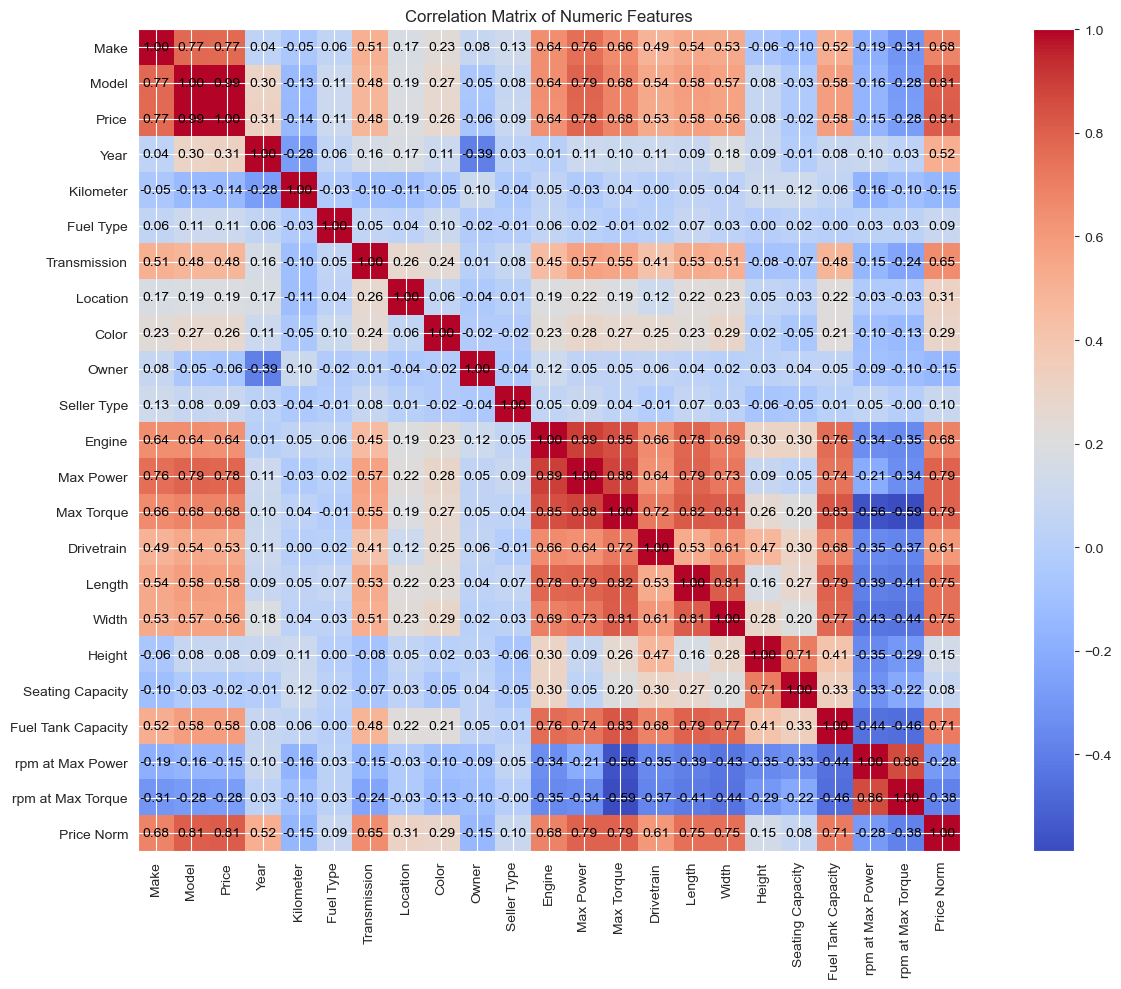

In [28]:
train_data_after_normalization.plot_corr_matrix(15, 10)

## Part V: Split dataset and tools to evaluate models

#### V.1: Split dataset

In [29]:
train_data = copy.deepcopy(train_data_after_normalization)
validation_data = copy.deepcopy(validation_data_after_normalization)
numeric_columns, object_columns = train_data.numeric_columns, train_data.object_columns
print(numeric_columns, len(numeric_columns))

train_data = train_data.data
validation_data = validation_data.data

# X_train, y_train from train_data
# X_val, y_val from validation_data

X_train = train_data.drop(columns=['Price', 'Price Norm'])
y_train = train_data['Price']

X_val = validation_data.drop(columns=['Price'])
y_val = validation_data['Price']

Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity', 'rpm at Max Power',
       'rpm at Max Torque', 'Price Norm'],
      dtype='object') 23


#### V.2: Tools to evaluate the models

In [30]:
# Function to evaluate the model
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    SSE = np.sum((y_true - y_pred) ** 2)
    SST = np.sum((y_true - np.mean(y_true)) ** 2) 
    return 1 - (SSE / SST) # R^2 = 1 - SSE/SST = SSR/SST

def evaluate_model(y_true, y_pred):
    model_eval = pd.DataFrame({
        'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2 Score'],
        'Value': [mse(y_true, y_pred), rmse(y_true, y_pred), mae(y_true, y_pred), r2_score(y_true, y_pred)]
    })

    return model_eval

In [31]:
def adjusted_r2_score(y_true, y_pred, n_features):
    n = len(y_true)  # sample size
    
    # Calculate regular R²
    SSE = np.sum((y_true - y_pred) ** 2)
    SST = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (SSE / SST)
    
    # Calculate adjusted R²
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    
    return adjusted_r2

## Part VI: Linear Regression models

#### VI.1: Simple Linear Regression model from Statistics's point of view
Based on Correlation coefficient map, **Model** maybe the best feature for model. We will prove it.

#### VI.2: Multiple Linear Regression model

#### VI.3: Polynomial Regression model

In [32]:
from itertools import combinations_with_replacement

In [33]:
class PolynomialFeatures:
    """
    Tạo ma trận đặc trưng đa thức.
    
    Parameters:
    -----------
    degree : int, mặc định=2
        Bậc của đa thức. 
    
    include_bias : bool, mặc định=True
        Nếu True, thêm cột toàn 1 vào ma trận (hằng số).
    
    interaction_only : bool, mặc định=False
        Nếu True, chỉ bao gồm các tương tác giữa các đặc trưng.
    """
    
    def __init__(self, degree=2, include_bias=True, interaction_only=False):
        self.degree = degree
        self.include_bias = include_bias
        self.interaction_only = interaction_only
    
    def fit(self, X, y=None):
        """
        Tính số lượng đặc trưng đầu ra.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng đầu vào.
        
        Returns
        -------
        self : object
        """
        n_samples, n_features = np.asarray(X).shape
        
        # Tính số lượng đặc trưng đầu ra
        combinations = []
        for d in range(0, self.degree + 1):
            if d == 0 and not self.include_bias:
                continue
            if d == 1:  # không thay đổi các đặc trưng ban đầu
                combinations.extend(range(n_features))
                continue
                
            if self.interaction_only:
                combinations.extend(combinations_with_replacement(range(n_features), d))
            else:
                combinations.extend([c for c in combinations_with_replacement(range(n_features), d) 
                                    if len(set(c)) == 1])
        
        self.n_output_features_ = len(combinations) + (1 if self.include_bias else 0)
        return self
    
    def transform(self, X):
        """
        Chuyển đổi đặc trưng thành đặc trưng đa thức.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng đầu vào.
        
        Returns
        -------
        XP : np.ndarray, shape (n_samples, n_output_features)
            Ma trận đặc trưng đa thức.
        """
        X = np.asarray(X)
        n_samples, n_features = X.shape
        self.n_features = n_features
        
        if n_features != self.n_input_features_:
            raise ValueError("X shape does not match training shape")
        
        # Khởi tạo ma trận đầu ra
        XP = np.ones((n_samples, 0))
        
        # Thêm hằng số nếu include_bias=True
        if self.include_bias:
            XP = np.hstack((np.ones((n_samples, 1)), XP))
        
        # Thêm đặc trưng ban đầu (bậc 1)
        if self.degree >= 1:
            XP = np.hstack((XP, X))
        
        # Tạo đặc trưng đa thức bậc cao hơn
        for d in range(2, self.degree + 1):
            if self.interaction_only:
                combs = [c for c in combinations_with_replacement(range(n_features), d)
                         if len(set(c)) > 1]
            else:
                combs = list(combinations_with_replacement(range(n_features), d))
            
            for comb in combs:
                new_col = np.ones((n_samples, 1))
                for i in comb:
                    new_col = new_col * X[:, i:i+1]
                XP = np.hstack((XP, new_col))
        
        return XP
    
    def fit_transform(self, X, y=None):
        """
        Fit và transform cùng một lúc.
        """
        return self.fit(X).transform(X)

In [34]:
class LinearRegression:
    """
    Hồi quy tuyến tính bằng OLS (Ordinary Least Squares).
    
    Parameters
    ----------
    fit_intercept : bool, mặc định=True
        Có tính hằng số hay không.
    """
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None
    
    def fit(self, X, y):
        """
        Huấn luyện mô hình hồi quy tuyến tính.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng.
        
        y : array-like, shape (n_samples,)
            Vector mục tiêu.
        
        Returns
        -------
        self : object
        """
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Add a column of ones for the intercept if fit_intercept=True
        if self.fit_intercept:
            X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
        else:
            X_with_intercept = X

        # Calculate coefficients using the normal equation: beta = (X^T X)^(-1) X^T y
        beta, residues, rank, s = np.linalg.lstsq(X_with_intercept, y, rcond=None)

        if self.fit_intercept:
            self.intercept_ = beta[0]
            self.coef_ = beta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = beta
            
        return self
    
    def predict(self, X):
        """
        Dự đoán sử dụng mô hình đã huấn luyện.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng.
        
        Returns
        -------
        y_pred : array, shape (n_samples,)
            Giá trị dự đoán.
        """
        X = np.asarray(X)
        return X.dot(self.coef_) + self.intercept_

In [35]:
class PolynomialRegression:
    """
    Mô hình hồi quy đa thức.
    
    Parameters
    ----------
    degree : int, mặc định=2
        Bậc của đa thức.
    
    include_bias : bool, mặc định=True
        Có thêm cột toàn 1 vào ma trận không.
    
    interaction_only : bool, mặc định=False
        Chỉ bao gồm các tương tác giữa các đặc trưng.
    """
    
    def __init__(self, degree=2, include_bias=True, interaction_only=False):
        self.degree = degree
        self.include_bias = include_bias
        self.interaction_only = interaction_only
        self.poly = PolynomialFeatures(degree=degree, 
                                       include_bias=include_bias,
                                       interaction_only=interaction_only)
        self.linear_regression = LinearRegression(fit_intercept=False if include_bias else True)
    
    def fit(self, X, y):
        """
        Huấn luyện mô hình hồi quy đa thức.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng.
        
        y : array-like, shape (n_samples,)
            Vector mục tiêu.
        
        Returns
        -------
        self : object
        """
        X_poly = self.poly.fit_transform(X)
        self.linear_regression.fit(X_poly, y)
        return self
    
    def predict(self, X):
        """
        Dự đoán sử dụng mô hình đã huấn luyện.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Ma trận đặc trưng.
        
        Returns
        -------
        y_pred : array, shape (n_samples,)
            Giá trị dự đoán.
        """
        X_poly = self.poly.transform(X)
        return self.linear_regression.predict(X_poly)

In [45]:
X_train_v3 = train_data.drop(columns=['Price', 'Price Norm'])
y_train_v3 = train_data['Price']

X_val_v3 = validation_data.drop(columns=['Price', 'Price Norm'])
y_val_v3 = validation_data['Price']

print("X_train_v3 shape:", X_train_v3.shape)
print("\nX_train_v3 columns:", X_train_v3.columns.tolist())
print("X_train_v3 shape:", X_val_v3.shape)
print("\nX_train_v3 columns:", X_val_v3.columns.tolist())


model = PolynomialRegression(degree=2)
model.fit(X_train_v3, y_train_v3)

y_pred = model.predict(X_val_v3)
model_eval = evaluate_model(y_val_v3, y_pred)
print(model_eval)
print("Adjuted R^2: ", adjusted_r2_score(y_val_v3, y_pred, X_val_v3.shape[1]))

X_train_v3 shape: (1317, 21)

X_train_v3 columns: ['Make', 'Model', 'Year', 'Kilometer', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'rpm at Max Power', 'rpm at Max Torque']
X_train_v3 shape: (330, 21)

X_train_v3 columns: ['Make', 'Model', 'Year', 'Kilometer', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'rpm at Max Power', 'rpm at Max Torque']
                    Metric         Value
0       Mean Squared Error  3.087079e+12
1  Root Mean Squared Error  1.757008e+06
2      Mean Absolute Error  1.002911e+06
3                R^2 Score  3.590197e-01
Adjuted R^2:  0.31531651160681917


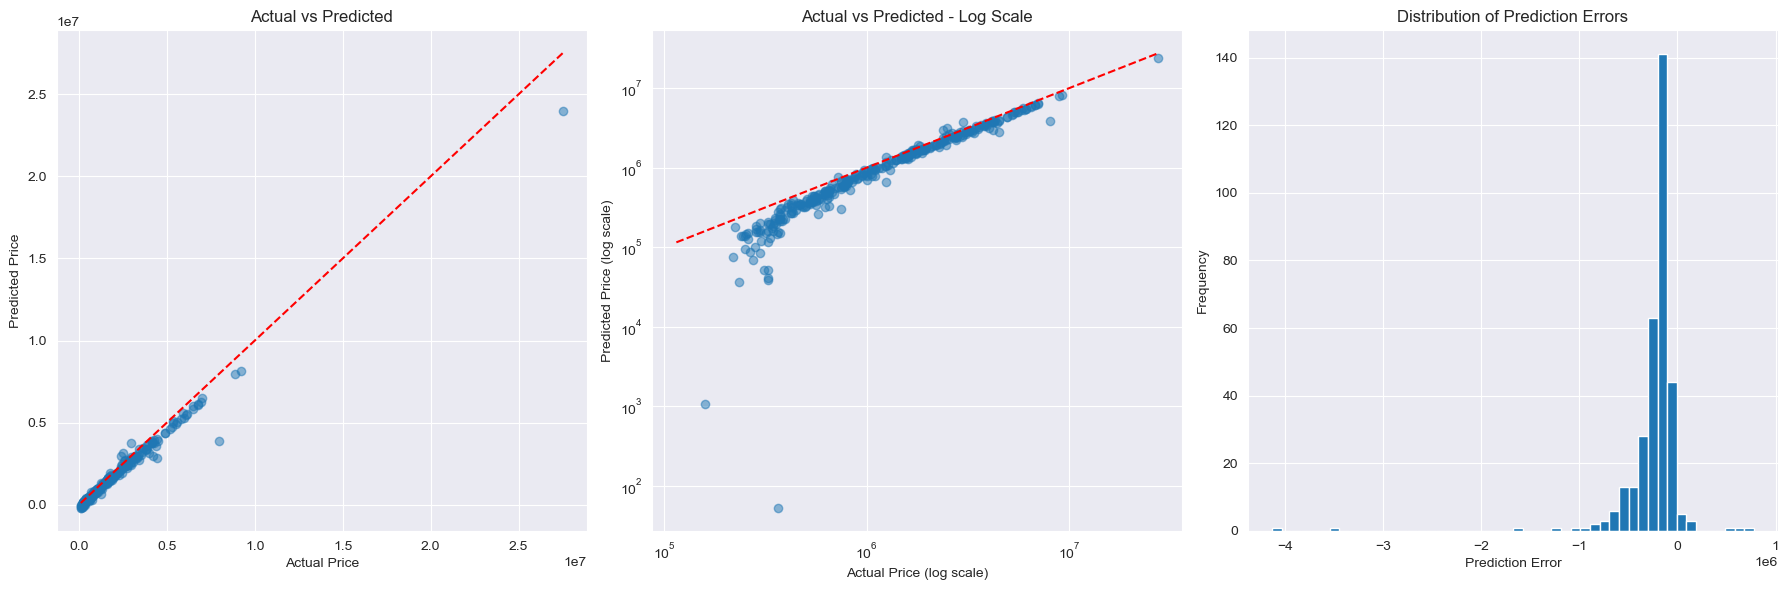

In [37]:
plt.figure(figsize=(18, 6))

# Plot 1: Scatter plot of predicted vs actual
plt.subplot(1, 3, 1)
plt.scatter(y_val_v3, y_pred, alpha=0.5)
plt.plot([y_val_v3.min(), y_val_v3.max()], [y_val_v3.min(), y_val_v3.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')

# Plot 2: Same scatter plot with log scale (helps with extreme values)
plt.subplot(1, 3, 2)
plt.scatter(y_val_v3, y_pred, alpha=0.5)
plt.plot([y_val_v3.min(), y_val_v3.max()], [y_val_v3.min(), y_val_v3.max()], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Price (log scale)')
plt.ylabel('Predicted Price (log scale)')
plt.title('Actual vs Predicted - Log Scale')

# Plot 3: Histogram of errors
plt.subplot(1, 3, 3)
errors = y_pred - y_val_v3
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
degrees = range(1, 6)  # Test degrees from 1 to 5
train_errors = []
val_errors = []

plt.figure(figsize=(12, 6))

for degree in degrees:
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_val = poly_features.transform(X_val)
    
    # Train model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Calculate errors
    train_pred = model.predict(X_poly_train)
    val_pred = model.predict(X_poly_val)
    
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    
    train_errors.append(train_mse)
    val_errors.append(val_mse)

# Plot on log scale due to potential large differences
plt.plot(degrees, train_errors, 'o-', label='Training Error')
plt.plot(degrees, val_errors, 'o-', label='Validation Error')
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Error vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: X shape does not match training shape

<Figure size 1200x600 with 0 Axes>

#### VI.4: Linear Regression model with PCA

## TEST SKLEARN POLYNOMIAL ##

In [141]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [143]:
quadratic_features = PolynomialFeatures(degree=3)
X_quadratic = quadratic_features.fit_transform(X_train)

regressor_quadratic = LinearRegression()
regressor_quadratic.fit(X_quadratic, y_train)

y_pred = regressor_quadratic.predict(X_quadratic)
model_eval = evaluate_model(y_train, y_pred)
print(model_eval)

X_val_quadratic = quadratic_features.transform(X_val)

# Make predictions on validation set
val_predictions = regressor_quadratic.predict(X_val_quadratic)

# Evaluate model on validation set
val_evaluation = evaluate_model(y_val, val_predictions)
print("Validation set evaluation:")
print(val_evaluation)

                    Metric         Value
0       Mean Squared Error  1.098529e+09
1  Root Mean Squared Error  3.314406e+04
2      Mean Absolute Error  1.362965e+03
3                R^2 Score  9.998092e-01
Validation set evaluation:
                    Metric         Value
0       Mean Squared Error  1.348745e+23
1  Root Mean Squared Error  3.672526e+11
2      Mean Absolute Error  1.794614e+11
3                R^2 Score -2.800444e+10
